# Lab 5: Neural Networks in practice

In [1]:
# Global imports and settings
from preamble import *
from tensorflow import keras
print("Using Keras",keras.__version__)
%matplotlib inline
plt.rcParams['figure.dpi'] = 125 # Use 300 for PDF, 100 for slides
# InteractiveShell.ast_node_interactivity = "all"
HTML('''<style>html, body{overflow-y: visible !important} .CodeMirror{min-width:105% !important;} .rise-enabled .CodeMirror, .rise-enabled .output_subarea{font-size:140%; line-height:1.2; overflow: visible;} .output_subarea pre{width:110%}</style>''') # For slides

Using TensorFlow backend.


Using Keras 2.3.1


## 3 examples
* Binary classification (of movie reviews)
* Multiclass classification (of news topics)
* Regression (of house prices)

Examples from _Deep Learning with Python_, by _François Chollet_

### Binary classification
* Dataset: 50,000 IMDB reviews, labeled positive (1) or negative (0)
    - Included in Keras, with a 50/50 train-test split
* Each row is one review, with only the 10,000 most frequent words retained
* Each word is replaced by a _word index_ (word ID)

In [2]:
from keras.datasets import imdb
# Download IMDB data with 10000 most frequent words
(train_data, train_labels), (test_data, test_labels) = imdb.load_data(num_words=10000)
print("Encoded review: ", train_data[0][0:10])

word_index = imdb.get_word_index()
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])
print("Original review: ", ' '.join([reverse_word_index.get(i - 3, '?') for i in train_data[0]][0:10]))

Encoded review:  [1, 14, 22, 16, 43, 530, 973, 1622, 1385, 65]
Original review:  ? this film was just brilliant casting location scenery story


In [3]:
# Custom implementation of one-hot-encoding
def vectorize_sequences(sequences, dimension=10000):
    results = np.zeros((len(sequences), dimension))
    for i, sequence in enumerate(sequences):
        results[i, sequence] = 1.  # set specific indices of results[i] to 1s
    return results
x_train = vectorize_sequences(train_data)
x_test = vectorize_sequences(test_data)
print("Encoded review: ", train_data[0][0:10])
print("One-hot-encoded review: ", x_train[0][0:10])

# Convert 0/1 labels to float
y_train = np.asarray(train_labels).astype('float32')
y_test = np.asarray(test_labels).astype('float32')

print("Label: ", y_train[0])

Encoded review:  [1, 14, 22, 16, 43, 530, 973, 1622, 1385, 65]
One-hot-encoded review:  [0. 1. 1. 0. 1. 1. 1. 1. 1. 1.]
Label:  1.0


#### Building the network
* We can solve this problem using a network of _Dense_ layers and the _ReLU_ activation function.
* How many layers? How many hidden units for layer?
    - Start with 2 layers of 16 hidden units each
    - We'll optimize this soon
* Output layer: single unit with _sigmoid_ activation function
    - Close to 1: positive review, close to 0: negative review

In [4]:
from tensorflow.keras import models
from tensorflow.keras import layers 

model = models.Sequential()
model.add(layers.Dense(16, activation='relu', input_shape=(10000,)))
model.add(layers.Dense(16, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['accuracy'])

Note: for more control, you can explictly create the optimizer, loss, and metrics:

``` python
from keras import optimizers
from keras import losses
from keras import metrics
model.compile(optimizer=optimizers.RMSprop(lr=0.001),
              loss=losses.binary_crossentropy,
              metrics=[metrics.binary_accuracy])
```

#### Model selection
* How many epochs do we need for training?
* Take a validation set of 10,000 samples from the training set
* Train the neural net and track the loss after every iteration on the validation set
    - This is returned as a `History` object by the `fit()` function 
* We start with 20 epochs in minibatches of 512 samples

In [5]:
x_val, partial_x_train = x_train[:10000], x_train[10000:]
y_val, partial_y_train = y_train[:10000], y_train[10000:] 
history = model.fit(partial_x_train, partial_y_train,
                    epochs=20, batch_size=512, verbose=0,
                    validation_data=(x_val, y_val))

We can now retrieve visualize the loss on the validation data
* The training loss keeps decreasing, due to gradient descent
* The validation loss peaks after a few epochs, after which the model starts to overfit

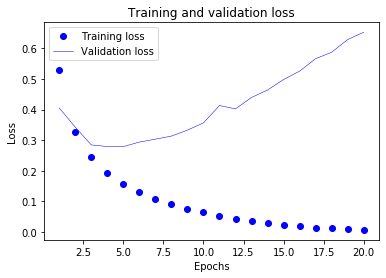

In [6]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

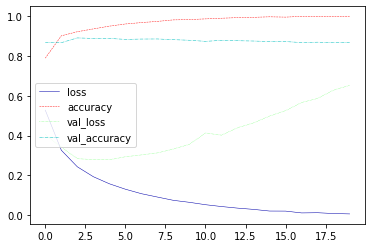

In [7]:
# Alternative plotting code
pd.DataFrame(history.history).plot();

We can also visualize the accuracy, with similar findings

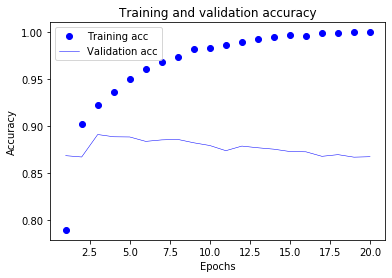

In [8]:
plt.clf()   # clear figure
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

#### Predictions
Out of curiosity, let's look at a few predictions:

In [10]:
predictions = model.predict(x_test)
print("Review 0: ", ' '.join([reverse_word_index.get(i - 3, '?') for i in test_data[0]]))
print("Predicted positiveness: ", predictions[0])
print("\nReview 16: ", ' '.join([reverse_word_index.get(i - 3, '?') for i in test_data[16]]))
print("Predicted positiveness: ", predictions[16])

Review 0:  ? please give this one a miss br br ? ? and the rest of the cast rendered terrible performances the show is flat flat flat br br i don't know how michael madison could have allowed this one on his plate he almost seemed to know this wasn't going to work out and his performance was quite ? so all you madison fans give this a miss
Predicted positiveness:  [0.008]

Review 16:  ? from 1996 first i watched this movie i feel never reach the end of my satisfaction i feel that i want to watch more and more until now my god i don't believe it was ten years ago and i can believe that i almost remember every word of the dialogues i love this movie and i love this novel absolutely perfection i love willem ? he has a strange voice to spell the words black night and i always say it for many times never being bored i love the music of it's so much made me come into another world deep in my heart anyone can feel what i feel and anyone could make the movie like this i don't believe so thanks

### Wrapping Keras models as scikit-learn estimators
* Model selection can be tedious in pure Keras
* We can use all the power of scikit-learn by wrapping Keras models

``` python
from keras.wrappers.scikit_learn import KerasClassifier, KerasRegressor
clf = KerasClassifier(model)
param_grid = {'epochs': [1, 5, 10],  # epochs is a fit parameter
              'hidden_size': [32, 64, 256]} # this is a make_model parameter
grid = GridSearchCV(clf, param_grid=param_grid, cv=3)
grid.fit(x_train, y_train)
```

In [11]:
from keras.wrappers.scikit_learn import KerasClassifier, KerasRegressor
from sklearn.model_selection import GridSearchCV

def make_model(optimizer="adam", hidden_size=32):
    model = models.Sequential()
    model.add(layers.Dense(16, activation='relu', input_shape=(10000,)))
    model.add(layers.Dense(16, activation='relu'))
    model.add(layers.Dense(1, activation='sigmoid'))

    model.compile(optimizer='rmsprop',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model

clf = KerasClassifier(make_model)
param_grid = {'epochs': [1, 5, 10],  # epochs is fit parameter, not in make_model!
              'hidden_size': [32, 64, 256],
              'verbose' : [0]}
grid = GridSearchCV(clf, param_grid=param_grid, cv=3)
grid.fit(x_train, y_train)

GridSearchCV(cv=3, error_score=nan,
             estimator=<keras.wrappers.scikit_learn.KerasClassifier object at 0x13fd3b2b0>,
             iid='deprecated', n_jobs=None,
             param_grid={'epochs': [1, 5, 10], 'hidden_size': [32, 64, 256],
                         'verbose': [0]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

Grid search results

In [12]:
res = pd.DataFrame(grid.cv_results_)
res.pivot_table(index=["param_epochs", "param_hidden_size"],
                values=['mean_train_score', "mean_test_score"])

KeyError: 'mean_train_score'

### Multi-class classification (topic classification)
* Dataset: 11,000 news stories, 46 topics
    - Included in Keras, with a 50/50 train-test split
* Each row is one news story, with only the 10,000 most frequent words retained
* Each word is replaced by a _word index_ (word ID)

In [ ]:
from keras.datasets import reuters

(train_data, train_labels), (test_data, test_labels) = reuters.load_data(num_words=10000)

word_index = reuters.get_word_index()
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])
# Note that our indices were offset by 3
# because 0, 1 and 2 are reserved indices for "padding", "start of sequence", and "unknown".
decoded_newswire = ' '.join([reverse_word_index.get(i - 3, '?') for i in train_data[0]])
print("News wire: ",decoded_newswire)
print("Encoded: ", train_data[0][0:20])
print("Topic: ",train_labels[0])

#### Preparing the data
* We have to vectorize the data again (using one-hot-encoding)
* We have to vectorize the labels as well, also using one-hot-encoding
    - We can use Keras' `to_categorical` again
    - This yields a vector of 46 floats (0/1) for every sample

In [ ]:
from keras.utils.np_utils import to_categorical
x_train = vectorize_sequences(train_data)
x_test = vectorize_sequences(test_data)
one_hot_train_labels = to_categorical(train_labels)
one_hot_test_labels = to_categorical(test_labels)

In [ ]:
model = models.Sequential()
model.add(layers.Dense(64, activation='relu', input_shape=(10000,)))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(46, activation='softmax'))
model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

#### Model selection
* Take a validation set from the training set
* Fit again with 20 epochs

In [ ]:
x_val, partial_x_train = x_train[:1000], x_train[1000:]
y_val, partial_y_train = one_hot_train_labels[:1000], one_hot_train_labels[1000:]

In [ ]:
history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=20, verbose=0,
                    batch_size=512,
                    validation_data=(x_val, y_val))

Loss curve:

In [ ]:
import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

Accuracy curve. Overfitting starts after about 8 epochs

In [ ]:
plt.clf()   # clear figure

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

Retrain with early stopping after 8 epochs and validate
``` python
model.fit(partial_x_train, partial_y_train, epochs=8, batch_size=512, verbose=0,)
result = model.evaluate(x_test, one_hot_test_labels)
```

In [ ]:
model.fit(partial_x_train, partial_y_train, epochs=8, batch_size=512, verbose=0)
result = model.evaluate(x_test, one_hot_test_labels)
print("Loss: {:.4f}, Accuracy: {:.4f}".format(*result))

### Regression
* Dataset: 506 examples of houses and sale prices (Boston)
    - Included in Keras, with a 1/5 train-test split
* Each row is one house price, described by numeric properties of the house and neighborhood
* Small dataset, non-normalized features

In [ ]:
from keras.datasets import boston_housing

(train_data, train_targets), (test_data, test_targets) =  boston_housing.load_data()

#### Preprocessing
* Neural nets work a lot better if we normalize the features first. 
* Keras has no built-in support so we have to do this manually (or with scikit-learn)
    - Again, be careful not to look at the test data during normalization
    
``` python
mean, std = train_data.mean(axis=0), train_data.std(axis=0)
train_data -= mean
train_data /= std
test_data -= mean
test_data /= std
```

In [ ]:
mean, std = train_data.mean(axis=0), train_data.std(axis=0)
train_data -= mean
train_data /= std

test_data -= mean
test_data /= std

#### Building the network
* This is a small dataset, so easy to overfit
    * We use 2 hidden layers of 64 units each
* Use smaller batches, more epochs
* Since we want scalar output, the output layer is one unit without activation
* Loss function is Mean Squared Error (bigger penalty)
* Evaluation metric is Mean Absolute Error (more interpretable)
* We will also use cross-validation, so we wrap the model building in a function, so that we can call it multiple times

In [ ]:
def build_model():
    model = models.Sequential()
    model.add(layers.Dense(64, activation='relu',
                           input_shape=(train_data.shape[1],)))
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(1))
    model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])
    return model

#### Cross-validation
* Keras does not have support for cross-validation
* Luckily we can wrap a Keras model as a scikit-learn estimate
* We can also implement cross-validation ourselves (see notebook)
* Generally speaking, cross-validation is tricky with neural nets
    * Some fold may not converge, or fluctuate on random initialization
    
``` python
clf = KerasClassifier(build_model)
score = cross_val_score(clf, train_data, train_targets, scoring='neg_mean_absolute_error', cv=4, fit_params={'epochs': 100, 'batch_size':1, 'verbose':0});
```

In [ ]:
# TODO: Check why MAE is different. Should actually use a pipeline
from sklearn.model_selection import cross_val_score
clf = KerasClassifier(build_model)
X = np.concatenate([train_data,test_data],axis=0)
y = np.concatenate([train_targets,test_targets],axis=0)
score = cross_val_score(clf, train_data, train_targets, scoring='neg_mean_absolute_error', cv=4,
                        fit_params={'epochs': 100, 'batch_size':1, 'verbose':0});
print("MAE: ", -np.mean(score))

In [ ]:
import numpy as np

k = 4
num_val_samples = len(train_data) // k
num_epochs = 100
all_scores = []
for i in range(k):
    print('processing fold #', i)
    # Prepare the validation data: data from partition # k
    val_data = train_data[i * num_val_samples: (i + 1) * num_val_samples]
    val_targets = train_targets[i * num_val_samples: (i + 1) * num_val_samples]

    # Prepare the training data: data from all other partitions
    partial_train_data = np.concatenate(
        [train_data[:i * num_val_samples],
         train_data[(i + 1) * num_val_samples:]],
        axis=0)
    partial_train_targets = np.concatenate(
        [train_targets[:i * num_val_samples],
         train_targets[(i + 1) * num_val_samples:]],
        axis=0)

    # Build the Keras model (already compiled)
    model = build_model()
    # Train the model (in silent mode, verbose=0)
    model.fit(partial_train_data, partial_train_targets,
              epochs=num_epochs, batch_size=1, verbose=0)
    # Evaluate the model on the validation data
    val_mse, val_mae = model.evaluate(val_data, val_targets, verbose=0)
    all_scores.append(val_mae)

In [ ]:
print("MAE: ", np.mean(all_scores))

Train for longer (500 epochs) and keep track of loss after every epoch  
(see code in notebook)

In [ ]:
from keras import backend as K
K.clear_session() # Memory clean-up

num_epochs = 500
all_mae_histories = []
for i in range(k):
    print('processing fold #', i)
    # Prepare the validation data: data from partition # k
    val_data = train_data[i * num_val_samples: (i + 1) * num_val_samples]
    val_targets = train_targets[i * num_val_samples: (i + 1) * num_val_samples]

    # Prepare the training data: data from all other partitions
    partial_train_data = np.concatenate(
        [train_data[:i * num_val_samples],
         train_data[(i + 1) * num_val_samples:]],
        axis=0)
    partial_train_targets = np.concatenate(
        [train_targets[:i * num_val_samples],
         train_targets[(i + 1) * num_val_samples:]],
        axis=0)

    # Build the Keras model (already compiled)
    model = build_model()
    # Train the model (in silent mode, verbose=0)
    history = model.fit(partial_train_data, partial_train_targets,
                        validation_data=(val_data, val_targets),
                        epochs=num_epochs, batch_size=1, verbose=0)
    mae_history = history.history['val_mae']
    all_mae_histories.append(mae_history)

The model starts overfitting after epoch 80

In [ ]:
average_mae_history = [
    np.mean([x[i] for x in all_mae_histories]) for i in range(num_epochs)]
plt.plot(range(1, len(average_mae_history) + 1), average_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()

Adding L1/L2 regularization

In [ ]:
from keras import regularizers

l2_model = models.Sequential()
l2_model.add(layers.Dense(16, kernel_regularizer=regularizers.l2(0.001),
                          activation='relu', input_shape=(10000,)))
l2_model.add(layers.Dense(16, kernel_regularizer=regularizers.l2(0.001),
                          activation='relu'))
l2_model.add(layers.Dense(1, activation='sigmoid'))

Adding dropout

In [ ]:
dpt_model = models.Sequential()
dpt_model.add(layers.Dense(16, activation='relu', input_shape=(10000,)))
dpt_model.add(layers.Dropout(0.5))
dpt_model.add(layers.Dense(16, activation='relu'))
dpt_model.add(layers.Dropout(0.5))
dpt_model.add(layers.Dense(1, activation='sigmoid'))

dpt_model.compile(optimizer='rmsprop',
                  loss='binary_crossentropy',
                  metrics=['acc'])

Dropout finds a better model, and overfits more slowly as well

### Word embeddings in Keras
* Uses a pre-trained embedding, obtained using GloVe
* See a complete example [here](https://blog.keras.io/using-pre-trained-word-embeddings-in-a-keras-model.html)

``` python
max_length = 20 # pad documents to a maximum number of words
vocab_size = 10000 # vocabulary size
embedding_length = 300 # vocabulary size
# define the model
model = Sequential()
model.add(Embedding(vocab_size, embedding_length, input_length=max_length))
model.add(Flatten())
model.add(Dense(1, activation='sigmoid'))
# compile the model
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])
# summarize the model
print(model.summary())
```